In [1]:
from gsnn.models.GSNN import GSNN
from gsnn.simulate.nx2pyg import nx2pyg 

import networkx as nx 
import torch 
from torch_geometric.data import HeteroData
from matplotlib import pyplot as plt
import matplotlib.patches as patches

%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/gsnn-lib/lib/python3.12/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/teddy/miniconda3/envs/gsnn-lib/lib/python3.12/site-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


# General Premise

The GSNN method is a way of including prior knowledge of variable interactions directly into neural architecture. Prior knowledge is specified using a Pytorch Geometric `HeteroData` object. The minimal requirements of this are: 

```python 
import torch_geometric as pyg 

data = pyg.data.HeteroData() 

data.edge_index_dict = {('input', 'to', 'function'):input_edge_index, 
						('function', 'to', 'function'): function_edge_index, 
						('function','to','output'):output_edge_index}

data.node_names_dict = {'input':input_names,
						'function':function_names,
						'output':output_names}

```

The edge indexes should be a torch LongTensor and the node names should be ordered respective to node indexing represented in the edge indicies. 

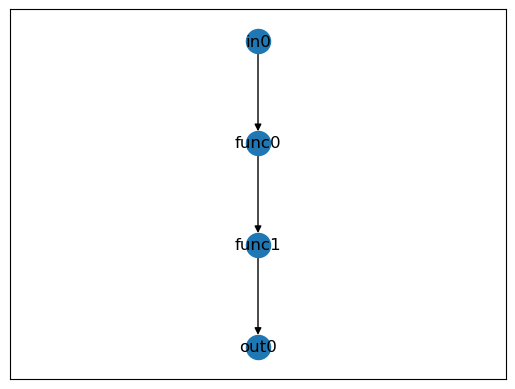

In [2]:
G = nx.DiGraph([('in0','func0'), ('func0', 'func1'), ('func1', 'out0')])
nx.draw_networkx(G, pos={'in0':(0,0), 'func0': (0,-1), 'func1':(0,-2), 'out0':(0,-3)})

In [3]:
data = nx2pyg(G, ['in0'], ['func0', 'func1'], ['out0'])
data

HeteroData(
  edge_index_dict={
    (input, to, function)=[2, 1],
    (function, to, function)=[2, 1],
    (function, to, output)=[2, 1],
  },
  node_names_dict={
    input=[1],
    function=[2],
    output=[1],
  }
)

In [4]:
# create some dummy data 
x = torch.randn((10,len(data.node_names_dict['input'])))

In [5]:
model = GSNN(edge_index_dict=data.edge_index_dict, 
             node_names_dict=data.node_names_dict, 
             channels = 3, 
             layers = 4)

In [6]:
# note that the output has size (Batch, num_outputs)
model(x)

tensor([[0.0112],
        [0.0086],
        [0.0117],
        [0.0474],
        [0.0446],
        [0.0111],
        [0.0116],
        [0.0352],
        [0.0112],
        [0.0116]], grad_fn=<IndexBackward0>)

In [7]:
model.ResBlocks[0]

ResBlock(
  (lin1): SparseLinear(
    (conv): Conv()
  )
  (norm1): GroupLayerNorm()
  (lin3): SparseLinear(
    (conv): Conv()
  )
  (nonlin): GELU(approximate='none')
)

## What is happening under the GSNN hood? 

In the plot below, we show the resulting internal structure of the GSNN. 

The "E1" node represents the input from node "in0"

Each edge in the graph below represents a trainable edge weight randomly initialized. 

The "NNx" nodes represent layer normalization and non-linearity operations (within gray bounding boxes). 

The "E0" node represents a latent channel in the layer. 

The "E2" node represents the predicted output and will be the resulting value output to the "out0" node. 

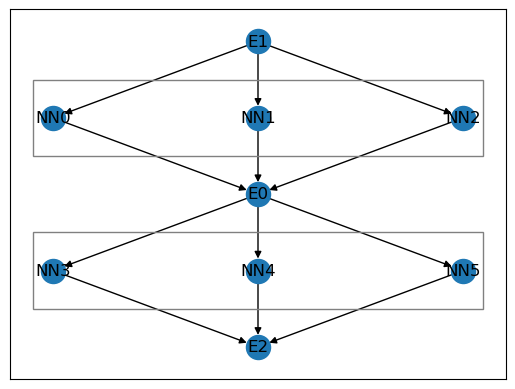

In [8]:
G2 = nx.DiGraph([('E'+str(u), 'NN'+str(v)) for u,v in zip(*model.ResBlocks[0].lin1.indices.detach().numpy())] + [('NN'+str(u),'E'+str(v)) for u,v in zip(*model.ResBlocks[0].lin3.indices.detach().numpy())]) 

fig, ax = plt.subplots()
nx.draw_networkx(G2, pos={'E1': (0,0),
                         'NN0': (-1,-1), 'NN1':(0,-1), 'NN2':(1,-1),
                         'E0':(0,-2),
                         'NN3':(-1,-3), 'NN4':(0,-3), 'NN5':(1,-3),
                         'E2':(0,-4)}, ax=ax) 

ax.add_patch(patches.Rectangle((-1.1, -1.5), 2.2, 1, linewidth=1, edgecolor='gray', facecolor='none'))
ax.add_patch(patches.Rectangle((-1.1, -3.5), 2.2, 1, linewidth=1, edgecolor='gray', facecolor='none'))

plt.show()

